In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import (
    Atlas, group_by_networks, plot_matrix, reshape_pvalues, block_block, plot_ordered_matrix
)
from bold_dementia.utils.iterables import unique

ATLAS = "gillig"
SOFT = False
ALPHA = config["alpha"]
atlas = Atlas.from_name(ATLAS, soft=SOFT)


In [2]:
expname = f"atlas-{ATLAS}_default_ols-cenanom"
matrices_path = Path(
    f"{config['output_dir']}/statresults/{expname}"
)
print(f"Loading matrices from {matrices_path}")
fdrmat = joblib.load(matrices_path / "pmat.joblib")
tstats = joblib.load(matrices_path / "statmap.joblib")

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)
labels = tuple(sorted(unique(atlas.macro_labels)))

Loading matrices from /homes_unix/jlegrand/data/Memento/output/statresults/atlas-gillig_default_ols-cenanom


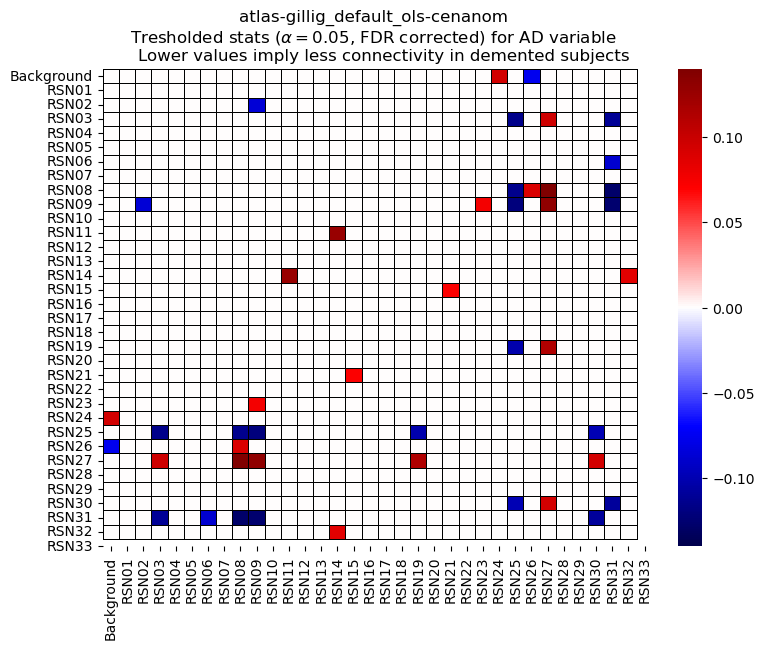

In [3]:
span = np.max(np.abs(thresholded_t))

if len(atlas.labels) < 35:
    plot_ordered_matrix(thresholded_t, atlas)
else:
    plot_matrix(thresholded_t, atlas)
plt.title(f"{expname}\nTresholded stats ($\\alpha = 0.05$, FDR corrected) for AD variable\n\
    Lower values imply less connectivity in demented subjects")
plt.show()

In [4]:
if ATLAS != "gillig":
    coords = atlas.get_coords()
    plotting.plot_connectome(
        thresholded_t, coords
    )
else:
    print("Not so iteresting to compute mass centers of networks obviously")


Not so iteresting to compute mass centers of networks obviously


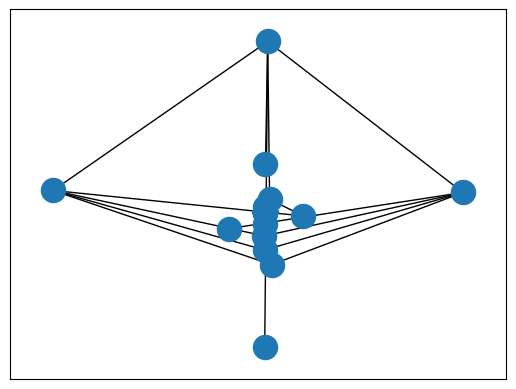

In [5]:
import networkx as nx

G = nx.from_numpy_array(thresholded_t, edge_attr="weight")

label_mapping = dict(zip(range(len(atlas.labels)), atlas.labels))

#pos = nx.spring_layout(G, seed=config["seed"], iterations=100)
pos = nx.spectral_layout(G)

nx.draw_networkx_nodes(G, pos)

nx.draw_networkx_edges(
    G,
    pos,
    edge_cmap="seismic"
)

#nx.draw_networkx_labels(
#    G,
#    pos,
#    font_size=8,
#    labels=label_mapping,
#)
plt.draw()

In [83]:
matrix_df.max()

RSN01    0.095145
RSN02   -0.000000
RSN03    0.000000
RSN04    0.097022
RSN05   -0.000000
RSN06    0.000000
RSN07   -0.000000
RSN08    0.000000
RSN09    0.140064
RSN10    0.131280
RSN11   -0.000000
RSN12    0.126283
RSN13    0.000000
RSN14    0.000000
RSN15    0.126283
RSN16    0.071241
RSN17    0.000000
RSN18   -0.000000
RSN19    0.000000
RSN20    0.113504
RSN21   -0.000000
RSN22    0.071241
RSN23   -0.000000
RSN24    0.076360
RSN25    0.095145
RSN26    0.000000
RSN27    0.090674
RSN28    0.140064
RSN29    0.000000
RSN30   -0.000000
RSN31    0.094070
RSN32    0.000000
RSN33    0.084683
dtype: float64

In [71]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
labels = atlas.labels
labels.pop(0)
matrix_df = pd.DataFrame(thresholded_t, index=labels, columns=labels)
ot = pd.DataFrame(tstats, index=labels, columns=labels)

links = []
msk = []

for source, row in matrix_df.iterrows():
    for target_rsn, val in row.items():
        if val > 0:
            colour = "red"
        elif val < 0:
            colour = "blue"
        elif val == 0:
            continue
            
        links.append(
            (source, target_rsn, colour)
        )
        
    msk.append(any(row.values != 0))
    
#matrix_df = matrix_df.loc[msk, msk]


# Sort df to group positive and negative networks together
#sort_idx = matrix_df.sum().sort_values().index
#matrix_df = matrix_df.loc[sort_idx, sort_idx]

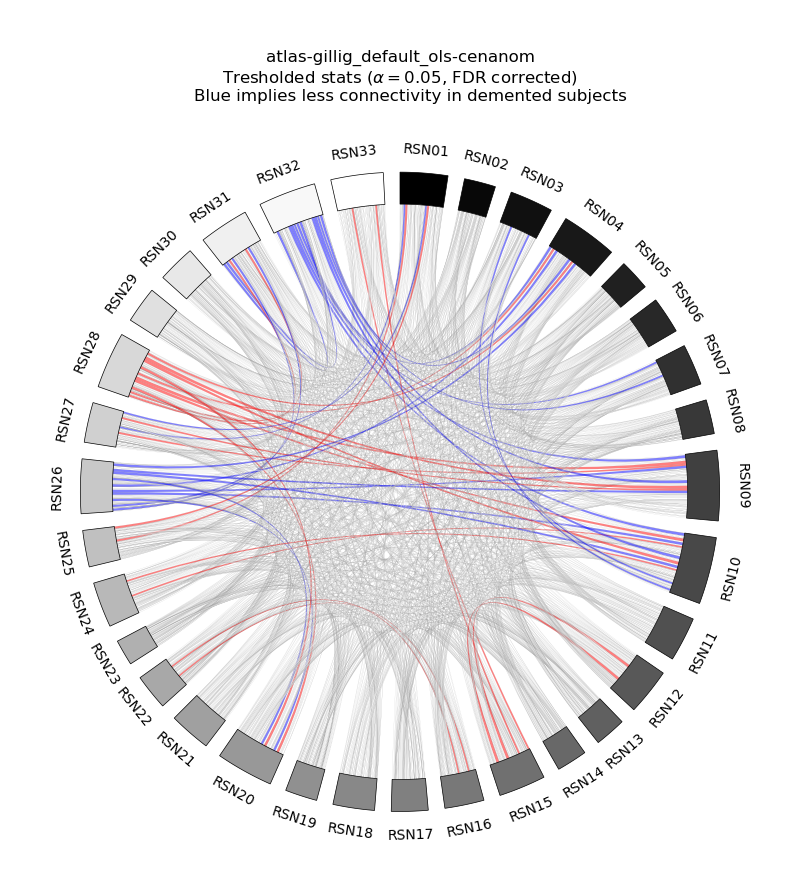

In [45]:
from pycirclize import Circos
import pandas as pd

md = np.abs(ot)

# Initialize from matrix (Can also directly load tsv matrix file)
circos = Circos.initialize_from_matrix(
    md,
    space=3,
    cmap="gray",
    link_cmap=links,
    ticks_kws={"label_size": 2},
    #label_kws=dict(size=10, adjust_rotation=False, r=110),
    #link_kws=dict(ec="black", lw=0.5),
    r_lim=(90, 100)
)

fig = circos.plotfig()
fig.suptitle(
    f"{expname}\nTresholded stats ($\\alpha = 0.05$, FDR corrected)\n\
    Blue implies less connectivity in demented subjects",
    y=1.01
)
plt.show()

In [73]:
circos_links = [
    ((a, 4, 6), (b, 4, 6), color)  for a, b, color in links
]

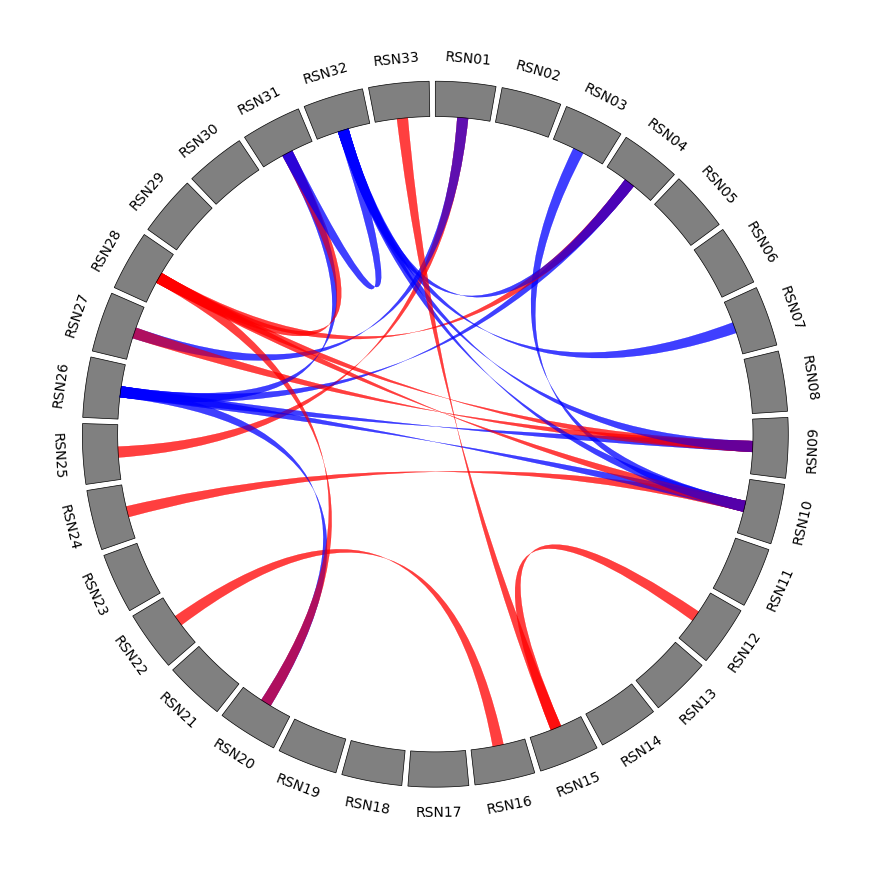

In [79]:
from pycirclize import Circos

networks = matrix_df.columns.to_list()
sectors = {n: 10 for n in networks}
circos = Circos(sectors, space=1)

cmap="gray",
link_cmap=links,
ticks_kws={"label_size": 2},
r_lim=(90, 100)
# TODO Name to color
for sector in circos.sectors:
    # Plot label, outer track axis & xticks
    sector.text(sector.name)
    outer_track = sector.add_track(r_lim)
    color = "gray"
    outer_track.axis(fc=color)


# Plot links
for link in circos_links:
    circos.link(*link[:2], color=link[2])


fig = circos.plotfig()